# MSc DS: Learning a full convariance Gaussian with missing data

In [10]:
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt

We load the Iris data set.

In [11]:
from sklearn.datasets import load_iris
data = load_iris(True)[0]

We now standardise the data:

In [12]:
xfull = ((data - np.mean(data,0))/np.std(data,0)).astype(np.float32)
n = xfull.shape[0] # number of observations
p = xfull.shape[1] # number of features

We remove 30% of the values

In [13]:
perc_miss = 0.3 # 30% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss) # binary mask that indicates which values are missing

We want to learn a Gaussian distribution:
$$p(x) = \mathcal{N}(x|\mu,\Sigma), $$
where $\Sigma$ is a not a diagonal matrix, using maximum likelihood. We'll use the Cholesky decomposition of $\Sigma$.

In [14]:
dim_triangular_matrix = int(p*(p+1)/2)

mu = tf.Variable(tf.random.normal([p]), dtype=tf.float32)
C = tf.Variable(tfp.math.fill_triangular(tf.random.normal([dim_triangular_matrix])), dtype=tf.float32) 

We first use define a function that can compute the likelihood of a complete data point.

In [15]:
@tf.function
def log_likelihood(x):
  L = C
  L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
  Sigma = tf.matmul(L,L, transpose_b=True)
  p_x = tfd.MultivariateNormalFullCovariance(loc = mu, covariance_matrix= Sigma)
  return(p_x.log_prob(x))

Now, I want you to write a function that computes the likelihood of an incomplete data point $\log p(x^{obs})$.

To help you, I'm showing you how to extract the relevant parts of $\mu$ and $\Sigma$ (which is a be tedious in TF), for a given mask $m \in \{0,1\}^4$:

The following lines remove the rows and columns of $\Sigma$ that correspond to missing values (i.e. zero entries of $m$).

In [23]:
# First I compute Sigma
L = C
L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
Sigma = tf.matmul(L,L, transpose_b=True)

# Then I remove what I must remove
q = tf.shape(tf.where(m))[0] #number of observed values
bin_mat = tf.reshape(tf.cast(m,tf.int32),[p,1]) * tf.reshape(tf.cast(m,tf.int32),[1,p]) #binary matrix that tells me which values to keep
Sigma_m = tf.reshape(tf.gather_nd(Sigma, tf.where(bin_mat)),[q,q])

In [41]:
@tf.function
def log_likelihood_incomplete(x,m):
  x = tf.squeeze(x)
  m = tf.squeeze(m)
  mu_m = mu[m]
  # First I compute Sigma
  L = C
  L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
  Sigma = tf.matmul(L,L, transpose_b=True)

  # Then I remove what I must remove
  q = tf.shape(tf.where(m))[0] #number of observed values
  bin_mat = tf.reshape(tf.cast(m,tf.int32),[p,1]) * tf.reshape(tf.cast(m,tf.int32),[1,p]) #binary matrix that tells me which values to keep
  Sigma_m = tf.reshape(tf.gather_nd(Sigma, tf.where(bin_mat)),[q,q])

  p_xobs = tfd.MultivariateNormalFullCovariance(loc = mu_m, covariance_matrix= Sigma_m) # distribution over R^q (i.e. observed values)
  return(p_xobs.log_prob(x[m])) # log p(xobs)

In [43]:
log_likelihood_incomplete(xmiss[0,:],mask[0,:]).numpy()

-0.82087445

Now we perform SGD!

In [44]:
params = [mu] + [C]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [45]:
def train_step(data,mask):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = -log_likelihood_incomplete(data,mask)  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, params)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params))  # Adam iteration

In [46]:
train_data_incomplete = tf.data.Dataset.from_tensor_slices((xmiss,mask)).shuffle(p).batch(1) # batches of size 1

In [47]:
EPOCHS = 601

for epoch in range(1,EPOCHS+1):
  for data,m in train_data_incomplete:
    train_step(data,m) # Adam iteration
  if (epoch % 100) == 1:
    ll_on_complete_data = tf.reduce_mean(log_likelihood(xfull)) # impossible to compute in real life settings
    print('Epoch  %g' %epoch)
    print('Training log-likelihood %g' %ll_on_complete_data.numpy())
    print('-----------')

Epoch  1
Training log-likelihood -18.7978
-----------
Epoch  101
Training log-likelihood -3.30215
-----------
Epoch  201
Training log-likelihood -3.30063
-----------
Epoch  301
Training log-likelihood -3.30219
-----------


KeyboardInterrupt: ignored

In [48]:
  L = C
  L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
  Sigma = tf.matmul(L,L, transpose_b=True)
  print(Sigma) # Computed only with 70% of the data

tf.Tensor(
[[ 1.0115297  -0.05388165  0.8580565   0.8165033 ]
 [-0.05388165  1.0935929  -0.40980443 -0.32636145]
 [ 0.8580565  -0.40980443  0.9773234   0.9539969 ]
 [ 0.8165033  -0.32636145  0.9539969   1.0201724 ]], shape=(4, 4), dtype=float32)


In [52]:
mu.numpy()

array([ 0.0399379 , -0.05777522,  0.02760777,  0.03380872], dtype=float32)

In [49]:
 np.cov(xfull, rowvar=False) # impossible to compute in real life settings

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343068],
       [-0.11835884,  1.0067114 , -0.43131554, -0.36858316],
       [ 0.87760447, -0.43131554,  1.0067114 ,  0.96932763],
       [ 0.82343068, -0.36858316,  0.96932763,  1.00671144]])

# Beyond the Gaussian assumption

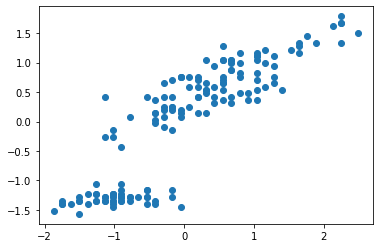

In [55]:
plt.scatter(xfull[:,0],xfull[:,2])
plt.show()

# A Gaussian mixture?

We want to learn a Gaussian mixture with identical covariances:
$$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k,\Sigma). $$

For simplicity, $\pi_k = 1/K$, and $K = 2$. We just have to learn $\mu_1,...,\mu_K$ and $\Sigma$.

In [56]:
dim_triangular_matrix = int(p*(p+1)/2)

mu1 = tf.Variable(tf.random.normal([p]), dtype=tf.float32)
mu2 = tf.Variable(tf.random.normal([p]), dtype=tf.float32)
C = tf.Variable(tfp.math.fill_triangular(tf.random.normal([dim_triangular_matrix])), dtype=tf.float32) 

First I define a GMM on complete data.

1.   Élément de liste
2.   Élément de liste



In [57]:
# Compute covariances from Choleski

L = C
L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
Sigma = tf.matmul(L,L, transpose_b=True)

p_x = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]), # equal proportions
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=[mu1,  # component 1
             mu2],  # component 2
        covariance_matrix=Sigma))

In [59]:
@tf.function
def log_likelihood_incomplete_gmm(x,m):
  x = tf.squeeze(x)
  m = tf.squeeze(m)
  mu1_m = mu1[m]
  mu2_m = mu2[m]
  # First I compute Sigma
  L = C
  L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
  Sigma = tf.matmul(L,L, transpose_b=True)

  # Then I remove what I must remove
  q = tf.shape(tf.where(m))[0] #number of observed values
  bin_mat = tf.reshape(tf.cast(m,tf.int32),[p,1]) * tf.reshape(tf.cast(m,tf.int32),[1,p]) #binary matrix that tells me which values to keep
  Sigma_m = tf.reshape(tf.gather_nd(Sigma, tf.where(bin_mat)),[q,q])

  p_xobs = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]), # equal proportions
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=[mu1_m,  # component 1
             mu2_m],  # component 2
        covariance_matrix=Sigma_m)) # distribution over R^q (i.e. observed values)
  return(p_xobs.log_prob(x[m])) # log p(xobs)

In [77]:
@tf.function
def log_likelihood_gmm(x):
  x = tf.squeeze(x)
  mu1_m = mu1
  mu2_m = mu2
  # First I compute Sigma
  L = C
  L = tf.linalg.set_diag(L,tf.exp(tf.linalg.diag_part(C)))
  Sigma = tf.matmul(L,L, transpose_b=True)

  p_x = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]), # equal proportions
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=[mu1,  # component 1
             mu2],  # component 2
        covariance_matrix=Sigma)) # distribution over R^q (i.e. observed values)
  return(p_x.log_prob(x)) # log p(xobs)

In [64]:
params_gmm = [mu1] + [mu2] + [C]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [67]:
def train_step(data,mask):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = -log_likelihood_incomplete_gmm(data,mask)  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, params_gmm)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params_gmm))  # Adam iteration

In [82]:
EPOCHS = 601

for epoch in range(1,EPOCHS+1):
  for data,m in train_data_incomplete:
    train_step(data,m) # Adam iteration
  if (epoch % 100) == 1:
    ll_on_complete_data = tf.reduce_mean(log_likelihood_gmm(xfull)) # impossible to compute in real life settings
    print('Epoch  %g' %epoch)
    print('Training log-likelihood %g' %ll_on_complete_data.numpy())
    print('-----------')

Epoch  1
Training log-likelihood -3.28068
-----------
Epoch  101
Training log-likelihood -3.27784
-----------
Epoch  201
Training log-likelihood -2.82202
-----------


KeyboardInterrupt: ignored

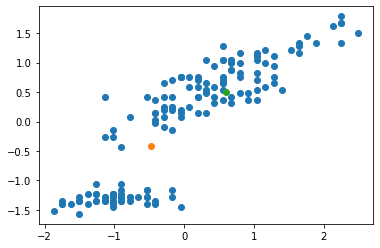

In [81]:
plt.scatter(xfull[:,0],xfull[:,2])
plt.scatter(mu1[0],mu1[2])
plt.scatter(mu2[0],mu2[2])
plt.show()

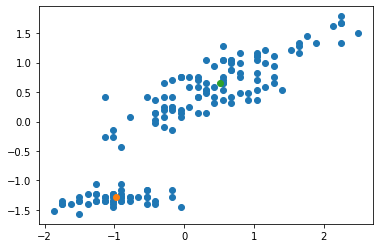

In [83]:
plt.scatter(xfull[:,0],xfull[:,2])
plt.scatter(mu1[0],mu1[2])
plt.scatter(mu2[0],mu2[2])
plt.show()

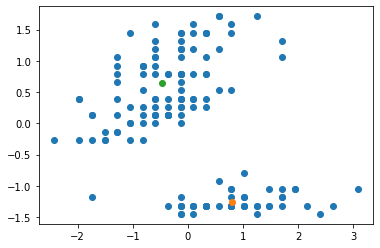

In [84]:
plt.scatter(xfull[:,1],xfull[:,3])
plt.scatter(mu1[1],mu1[3])
plt.scatter(mu2[1],mu2[3])
plt.show()